In [2]:
%pip install librosa sklearn matplotlib numpy umap emblaze

import os
import fnmatch
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [3]:
def find_audio_files(directory, extensions=('*.wav', '*.mp3', '*.flac', '*.ogg')):
    audio_files = []
    for root, _, filenames in os.walk(directory):
        for ext in extensions:
            for filename in fnmatch.filter(filenames, ext):
                audio_files.append(os.path.join(root, filename))
    return audio_files

samples_dir = "/home/jovyan/work/fox-samples"

# Load and process audio samples
audio_files = find_audio_files(samples_dir)
print(audio_files)

['/home/jovyan/work/fox-samples/fx/FX_Hits/Fox_FX_oneshot_zap_05.wav', '/home/jovyan/work/fox-samples/fx/FX_Hits/Fox_FX_impact_crashreal_06.wav', '/home/jovyan/work/fox-samples/fx/FX_Hits/Fox_FX_oneshot_zap_06.wav', '/home/jovyan/work/fox-samples/fx/FX_Hits/Fox_FX_impact_crash_02.wav', '/home/jovyan/work/fox-samples/fx/FX_Hits/Fox_FX_oneshot_zap_01.wav', '/home/jovyan/work/fox-samples/Vocal/oneshots/Fox_Vocal_oneshot_yeah_05.wav', '/home/jovyan/work/fox-samples/Vocal/oneshots/Fox_Vocal_oneshot_oh_01.wav', '/home/jovyan/work/fox-samples/Vocal/oneshots/Fox_Vocal_oneshot_laugh_01.wav', '/home/jovyan/work/fox-samples/Vocal/oneshots/Fox_Vocal_oneshot_ohmygod_01.wav', '/home/jovyan/work/fox-samples/Vocal/oneshots/Fox_Vocal_oneshot_ahh_02.wav', '/home/jovyan/work/fox-samples/Vocal/oneshots/Fox_Vocal_oneshot_uhh_09.wav', '/home/jovyan/work/fox-samples/Vocal/oneshots/Fox_Vocal_oneshot_yeah_09.wav', '/home/jovyan/work/fox-samples/Vocal/oneshots/Fox_Vocal_oneshot_yeah_01.wav', '/home/jovyan/work/

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


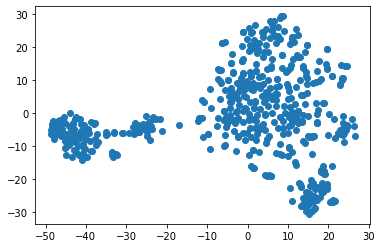

In [15]:
from scipy.interpolate import interp1d
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter

fixed_length = 100
fft_size = 512 # 2048
hop_length = fft_size//8

# if true, mfccs are stretched or folded to fixed_length rather than truncated/padded
stretch_and_fold = True

def fold_mfcc(mfcc, fixed_length, sigma=2):
    n_mfcc, n_frames = mfcc.shape
    mfcc_filtered = gaussian_filter(mfcc, sigma=(0, sigma))
    
    step = n_frames // fixed_length
    mfcc_folded = np.zeros((n_mfcc, fixed_length))
    
    for i in range(fixed_length):
        start = i * step
        end = (i + 1) * step
        mfcc_folded[:, i] = np.mean(mfcc_filtered[:, start:end], axis=1)
    
    return mfcc_folded

def process_mfcc(mfcc, fixed_length):
    n_mfcc, n_frames = mfcc.shape
    if n_frames < fixed_length:
        x = np.linspace(0, n_frames - 1, fixed_length)
        mfcc_stretched = np.zeros((n_mfcc, fixed_length))
        for i in range(n_mfcc):
            interpolator = interp1d(range(n_frames), mfcc[i], kind='linear', fill_value="extrapolate")
            mfcc_stretched[i] = interpolator(x)
        return mfcc_stretched
    elif n_frames > fixed_length:
        mfcc_folded = fold_mfcc(mfcc, fixed_length)
        return mfcc_folded
    else:
        return mfcc

mfccs = []
for file in audio_files:
    y, sr = librosa.load(file)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=fft_size, hop_length=hop_length)
    
    if stretch_and_fold:
        mfcc_processed = process_mfcc(mfcc, fixed_length)
    else:
        if len(mfcc[0]) < fixed_length:
            mfcc_processed = np.pad(mfcc, ((0, 0), (0, fixed_length - len(mfcc[0]))), mode='constant')
        else:
            mfcc_processed = mfcc[:, :fixed_length]
    
    mfccs.append(mfcc_processed.ravel())

# Standardize features
scaler = StandardScaler()
mfccs_scaled = scaler.fit_transform(mfccs)

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
embeddings = tsne.fit_transform(mfccs_scaled)

# Plot 2D embeddings
plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.show()

In [22]:
import math
import emblaze
from emblaze import Field, ProjectionTechnique
import os

positions = mfccs_scaled
names = [os.path.splitext(os.path.basename(file))[0] for file in audio_files]

def colorize(sample_name: str):
    lower_sample_name = sample_name.lower()
    if 'vocal' in lower_sample_name:
        return 'vocal'
    elif 'kick' in lower_sample_name:
        return 'kick'
    elif 'snare' in lower_sample_name:
        return 'snare'
    elif 'fx' in lower_sample_name:
        return 'fx'
    elif 'perc' in lower_sample_name:
        return 'perc'
    elif 'hat' in lower_sample_name:
        return 'hat'
    else:
        return 'other'

colors = [colorize(name) for name in names]
sizes = [1 for _ in range(len(embeddings))]

emb = emblaze.Embedding({Field.POSITION: positions, Field.NAME: names, Field.COLOR: colors, Field.RADIUS: sizes}, n_neighbors=20)
emb.compute_neighbors(metric='euclidean')

variants = emblaze.EmbeddingSet([
    emb.project(method=ProjectionTechnique.TSNE, perplexity=40, learning_rate='auto', init='pca', early_exaggeration=1.3),
    emb.project(method=ProjectionTechnique.UMAP, n_neighbors=10, min_dist=0.2, metric='euclidean'),
    emb.project(method=ProjectionTechnique.UMAP, n_neighbors=15, min_dist=0.2, metric='euclidean'),
    emb.project(method=ProjectionTechnique.UMAP, n_neighbors=20, min_dist=0.2, metric='euclidean'),
    emb.project(method=ProjectionTechnique.UMAP, n_neighbors=40, min_dist=0.2, metric='euclidean'),
])

thumbnails = emblaze.TextThumbnails(names)
w = emblaze.Viewer(embeddings=variants, thumbnails=thumbnails)
w

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  r

Viewer(colorScheme='tableau', data={'data': [{'_format': 'compressed', '_idtype': 'u2', '_length': 513, 'ids':…